In [15]:
num_epochs = 1
device = 'cpu'
frames_path = '/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/frames'


# Custom Dataset (BA)

In [9]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class CustomFramesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        for class_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    image = Image.open(img_path).convert("RGB")
                    if self.transform:
                        image = self.transform(image)
                    self.images.append(image)
        print(f"Loaded {len(self.images)} images.") # Debugging line

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

# MODEL

In [10]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [16]:
dataset = CustomFramesDataset(root_dir=frames_path)

Loaded 3831 images.


# Pretrain MAE

In [27]:
def mask_image(image, mask_size):
    mask = torch.ones_like(image)
    mask[:, :mask_size, :mask_size] = 0
    return image * mask

from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

# Define your dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
dataset = CustomFramesDataset(root_dir=frames_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize your model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    i=1
    for images in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False):
        
        images = images.to(device)
        masked_images = mask_image(images, mask_size=64) # Adjust mask_size as needed
        outputs = model(masked_images)
        loss = criterion(outputs, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Remove the break statement if you want to train for more than one batch per epoch
        i += 1
        if i > 3:
            break # after i batches
    # Save the model after each epoch
    torch.save(model.state_dict(), f"model_saves_every_epoch.pth")

Loaded 3831 images.


# Eval


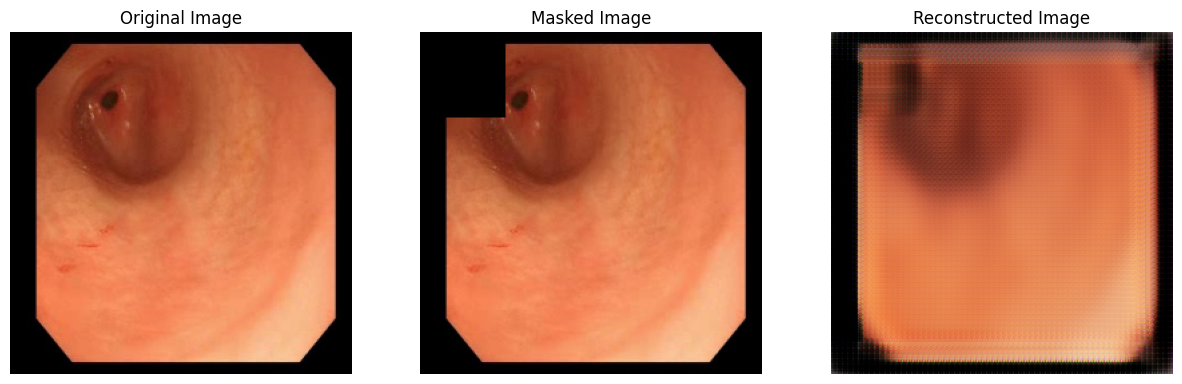

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming `images` is your batch of images, `reconstructed` is the reconstructed images,
# and `mask_image` is a function that applies the mask to an image

# For simplicity, let's assume you're working with the first image in the batch
image = images[5].cpu().numpy().transpose(1, 2, 0)

# Apply the mask to the image
masked_image = mask_image(images[5], mask_size=64) # Adjust mask_size as needed

# Pass the masked image through the model to get the reconstructed image
reconstructed_image = model(masked_image).detach().cpu().numpy().transpose(1, 2, 0)

# Plot original, masked, and reconstruction side by side
plt.figure(figsize=(15, 5))

# Display original
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Display masked image
plt.subplot(1, 3, 2)
plt.imshow(masked_image.cpu().numpy().transpose(1, 2, 0), cmap='gray')
plt.title('Masked Image')
plt.axis('off')

# Display reconstruction
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()